<a href="https://www.bigdatauniversity.com"><img src="https://ibm.box.com/shared/static/cw2c7r3o20w9zn8gkecaeyjhgw3xdgbj.png" width="400" align="center"></a>

<h1 align="center"><font size="5">Classification with Python</font></h1>

In this notebook we try to practice all the classification algorithms that we learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Lets first load required libraries:

In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

Lets download the dataset

In [2]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2020-07-30 19:36:32--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

100%[======================================>] 23,101      --.-K/s   in 0.002s  

2020-07-30 19:36:32 (12.0 MB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File  

In [3]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [4]:
df.shape

(346, 10)

### Convert to date time object 

In [5]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing



Let’s see how many of each class is in our data set 

In [6]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to underestand data better:

In [7]:
# notice: installing seaborn might takes a few minutes
!conda install -c anaconda seaborn -y

Solving environment: done

# All requested packages already installed.



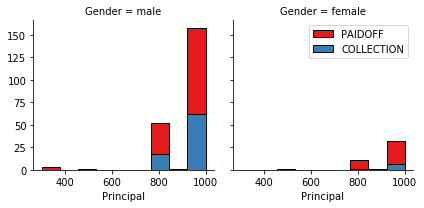

In [8]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

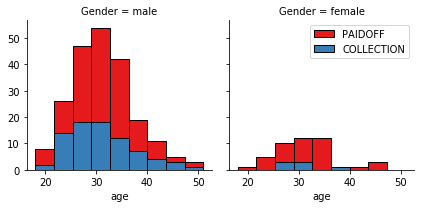

In [9]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction

### Lets look at the day of the week people get the loan 

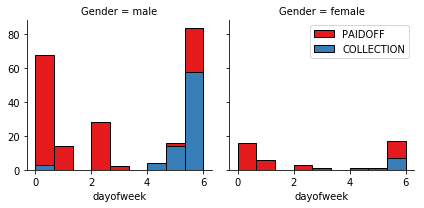

In [10]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 

In [11]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values

Lets look at gender:

In [12]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Lets convert male to 0 and female to 1:


In [13]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding  
#### How about education?

In [14]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Feature before One Hot Encoding

In [15]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to convert categorical variables to binary variables and append them to the feature Data Frame 

In [16]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature selection

Lets define feature sets, X:

In [17]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our labels?

In [18]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Normalize Data 

Data Standardization give data zero mean and unit variance (technically should be done after train test split )

In [19]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:1: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  if __name__ == '__main__':


array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification 

Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression



__ Notice:__ 
- You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
- You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
- You should include the code of the algorithm in the following cells.

# K Nearest Neighbor(KNN)
Notice: You should find the best k to build the model with the best accuracy.  
**warning:** You should not use the __loan_test.csv__ for finding the best k, however, you can split your train_loan.csv into train and test to find the best __k__.

In [20]:
# In order to train the KNN model, let's split the original data into train (80% of samples) and test (20% of samples) 
# data sets. This is a good technique for avoiding overfitting in the model, and will provide more realistic
# assessment of the algorithm performance for predicting out-of-sample values.
#
# On the other hand, by not using the full data set, we are not able to fully capture the algorithm performance.
# One way to overcome this problem is to use Cross Validation, which splits the data into "partitions" and runs
# the algorithm multiple times, using one partition as the test set and the others as the training set, until
# all combinations are exausted. As a result, we can average the scores to obtain a more realistic generalization 
# performance of the algorithm.

# Import the necessary objects and functions
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.model_selection import cross_val_score

# Create two lists for storing the corresponding k's and mean accuracies
k_list = []
mean_accuracy_list = []

# Define the range of k's we are going to test
min_k = 1
max_k = 60

# Run the KNN classifier for each value of k (number of neighbors)
for k in range(min_k, max_k+1):
    # Create a KNN classifier and run the cross validation using 5 partitions 
    knn = KNeighborsClassifier(n_neighbors = k)
    scores = cross_val_score( knn, X, y, cv=5)
    
    # Calculate the the mean score
    mean_accuracy = scores.mean()
    
    # Store the results
    k_list.append(k)
    mean_accuracy_list.append(mean_accuracy)

# Create a table with the corresponding k and accuracy values
results = pd.DataFrame( data = {'k': k_list, 'Mean_accuracy': mean_accuracy_list} )
results

,k,Mean_accuracy
0,1,0.676687
1,2,0.647909
2,3,0.699669
3,4,0.691139
4,5,0.719917
5,6,0.699710
6,7,0.722650
7,8,0.673665
8,9,0.685217
9,10,0.662236


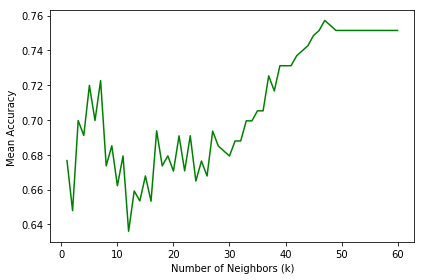

In [21]:
# Plot the accuracy of the model as a function of k, to analyze if there is a trend
plt.plot(results[['k']], results[['Mean_accuracy']],'g')
plt.ylabel('Mean Accuracy ')
plt.xlabel('Number of Neighbors (k)')
plt.tight_layout()
plt.show()


In [22]:
# Extract the rows that contain the highest accuracy from the results table
best_results = results[results.Mean_accuracy == max(mean_accuracy_list)]

# Determines the best value of k, i.e, the minimum value of k that leads to the highest accuracy
best_k = min(best_results['k'].values)

print("The best k is", best_k)

# We can see that the best performance of the KNN algotithm, for this data set, is achieved with k=47

# So, create a knn classifier with the best k and train the model again with the entire X dataset, 
# that will be used in the end for the final comparison of algorithms
knn = KNeighborsClassifier(n_neighbors = best_k)
knn.fit(X, y)

The best k is 47


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=47, p=2,
           weights='uniform')

# Decision Tree

In [23]:
# Install the GraphViz module, that will be used for visualization of the decision tree
# It may take a few minutes...
!conda install -c anaconda python-graphviz -y

Solving environment: done

# All requested packages already installed.



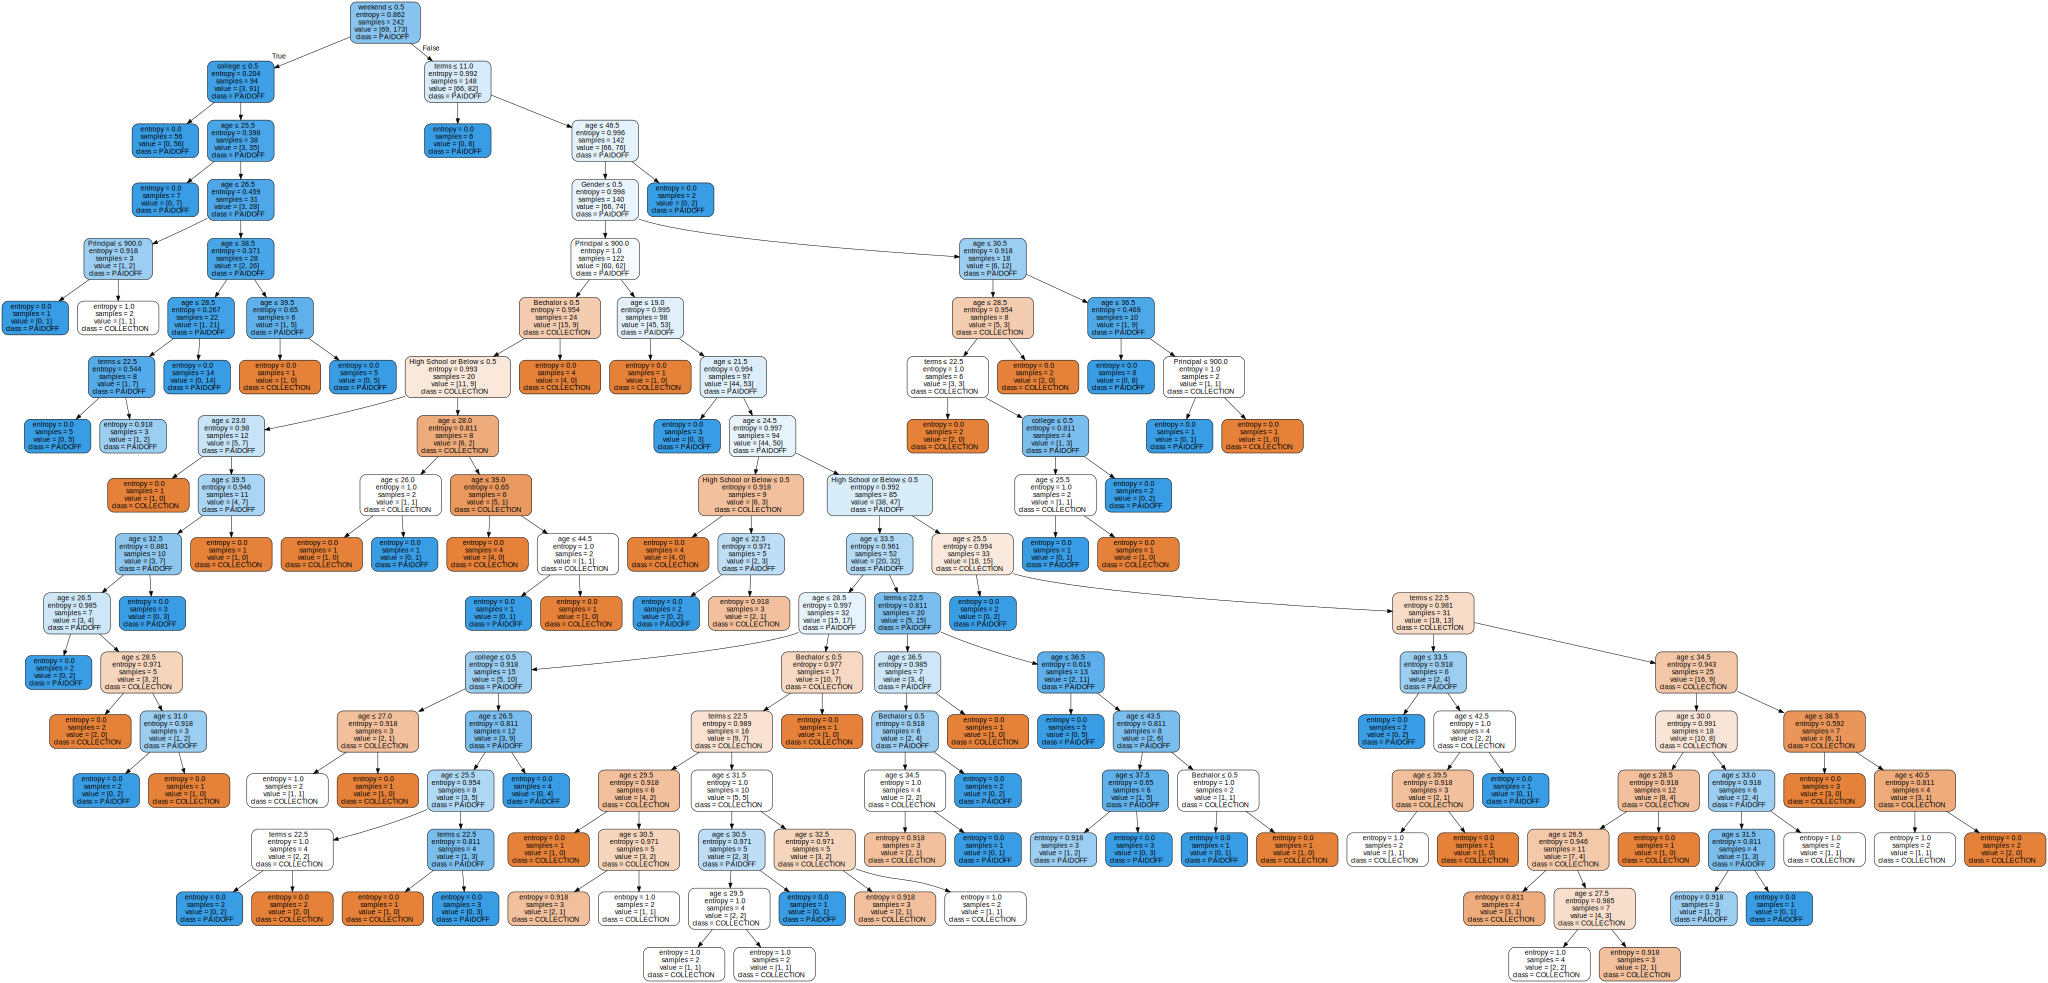

In [24]:
# Import the necessary objects and functions
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from graphviz import Source
from sklearn import metrics
from sklearn.model_selection import train_test_split

# Select the data that will be used. Instead of using X, that contains normalized data, we'll use the original Feature set, 
# to make it easier to visualize the decision tree
X_dt = Feature
y_dt = y

# Extract the features and classes names, for displaying the tree
feature_names_dt = X_dt.columns
target_names_dt = np.unique(y_dt)

# Split the data in two datasets: train (70%) and test data (30%)
X_train_dt, X_test_dt, y_train_dt, y_test_dt = train_test_split(X_dt, y_dt, test_size=0.3, random_state=0)

# Build and train decision tree model. We are not going to specify a max depth and let the algorithm create
# a tree as deep as necessary
loan_tree = DecisionTreeClassifier(criterion="entropy")
loan_tree.fit( X_train_dt, y_train_dt )

# Plot the decision tree
dot = export_graphviz(loan_tree, out_file=None, feature_names=feature_names_dt, class_names=target_names_dt, filled=True, rounded=True, special_characters=True) 
graph = Source(dot)
graph

In [25]:
# Print the model accuracy running the test data
yhat_dt = loan_tree.predict( X_test_dt )
print( "First attempt | Decision Tree's Accuracy: ", metrics.accuracy_score(y_test_dt, yhat_dt) )

# Also, evaluate the accuracy with cross validation technique
scores = cross_val_score( loan_tree, X_dt, y_dt, cv=5 )
print("First attempt | Mean accuracy=", scores.mean())

First attempt | Decision Tree's Accuracy:  0.6826923076923077
First attempt | Mean accuracy= 0.6537888198757764


**Analysis:** This decision tree seems to be too complex and still cannot predict very accurately, with a 68% accuracy. We can see many leafs with high entropy, which means we can expect a large error in these cases. 

 ## Decision tree - second attempt
One hypothesis for the not so good performance is that this dataset is unbalanced, i.e., approximately 25% of the cases are labelled COLLECTION and 75% are PAIDOFF, which could bias the model.
An alternative is to use the 'balanced' mode for class_weight parameter of the algorithm, which will use values of y to automatically adjust weights inversely proportional to class frequencies in the input data. This will give higher importance for the COLLECTION cases. Let's see if this change can improve the algorithm

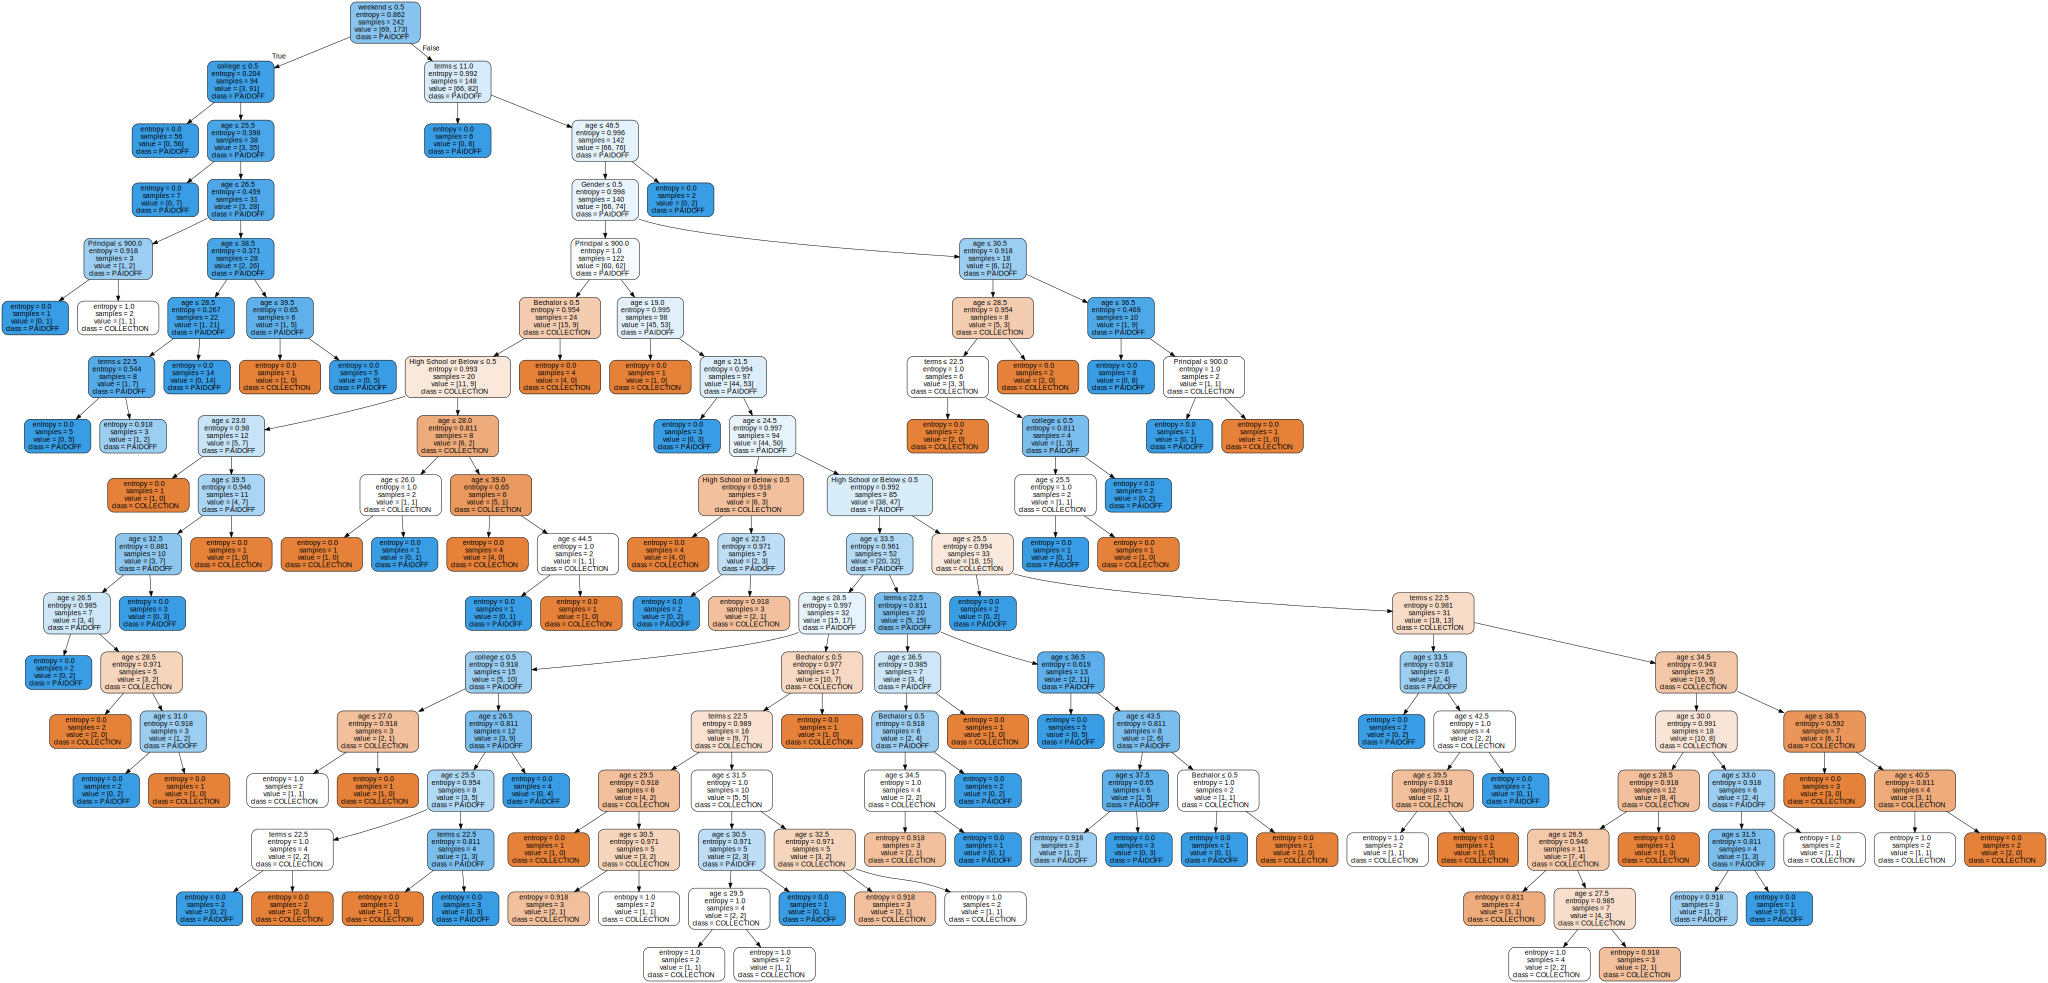

In [26]:
# Build and train decision tree model
loan_tree2 = DecisionTreeClassifier(criterion="entropy", class_weight='balanced')
loan_tree2.fit( X_train_dt, y_train_dt )

# Plot the decision tree
dot2 = export_graphviz(loan_tree2, out_file=None, feature_names=feature_names_dt, class_names=target_names_dt, filled=True, rounded=True, special_characters=True) 
graph2 = Source(dot)
graph2

In [27]:
# Calculate the model accuracy using the test dataset
yhat2_dt = loan_tree2.predict( X_test_dt )
print( "Second attempt | Decision Tree's Accuracy: ", metrics.accuracy_score(y_test_dt, yhat2_dt) )

# Also, evaluate the accuracy with cross validation technique
scores2 = cross_val_score( loan_tree2, X_dt, y_dt, cv=5 )
print("Second attempt - Mean accuracy=", scores2.mean())

Second attempt | Decision Tree's Accuracy:  0.6826923076923077
Second attempt - Mean accuracy= 0.6565631469979296


**Analysis:** Although the decision tree built in the second attempt is completely different than in the first attempt, the accuracy is exactly the same for the X_test_dt data set, and slightly worse in the cross validation, which is surprising for me! Let's try something else.

## Decision Tree - Third Attempt

In this third attempt to improve the algorithm, let's explore the effect of the decision tree depth on the accuracy.

In [28]:
# Specify the max_depth limits for the iteration
min_depth = 4
max_depth = 20

print("Third attempt")

# Iterate through different max_depth values and print the model accuracy using cross validation technique 
for depth in range(min_depth, max_depth+1):
    dtree = DecisionTreeClassifier(criterion="entropy", class_weight="balanced", max_depth=depth)
    scores = cross_val_score( dtree, X_dt, y_dt, cv=5 )
    print("Max Depth:", depth, " Mean accuracy=", scores.mean())
    


Third attempt
Max Depth: 4  Mean accuracy= 0.6539130434782608
Max Depth: 5  Mean accuracy= 0.6655072463768116
Max Depth: 6  Mean accuracy= 0.6481159420289855
Max Depth: 7  Mean accuracy= 0.6508902691511388
Max Depth: 8  Mean accuracy= 0.6508074534161492
Max Depth: 9  Mean accuracy= 0.6305175983436853
Max Depth: 10  Mean accuracy= 0.6593788819875775
Max Depth: 11  Mean accuracy= 0.6507660455486542
Max Depth: 12  Mean accuracy= 0.6448861283643892
Max Depth: 13  Mean accuracy= 0.6506832298136646
Max Depth: 14  Mean accuracy= 0.6449275362318841
Max Depth: 15  Mean accuracy= 0.6507660455486542
Max Depth: 16  Mean accuracy= 0.6536645962732919
Max Depth: 17  Mean accuracy= 0.6565631469979296
Max Depth: 18  Mean accuracy= 0.6536645962732919
Max Depth: 19  Mean accuracy= 0.6537060041407867
Max Depth: 20  Mean accuracy= 0.6565631469979296


**Analysis:** The third attempt to improve the algorithm by controlling the maximum decision tree depth also hasn't worked. 

In [29]:
# So, let's stick with our first decision tree model.
# Instantiate and train the final model
decision_tree = DecisionTreeClassifier( criterion="entropy" )
decision_tree.fit( X, y )

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

 # Support Vector Machine

 # Logistic Regression

# Model Evaluation using Test set

In [ ]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

First, download and load the test set:

In [ ]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

### Load Test set for evaluation 

In [ ]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

In [ ]:
# Calculate other model evaluation metrics
knn_jaccard = jaccard_similarity_score( y_test_dt, yhat_dt )
knn_f1score = f1_score( y_test_dt, yhat_dt, average='binary', pos_label='COLLECTION' )  # positive = "COLLECTION"
knn_logloss = log_loss( y_true=y_test_dt, y_pred=yhat_dt)
knn_metrics = pd.DataFrame( {'Algorithm':['KNN'], 'Jaccard':[knn_jaccard], 'F1-score':[knn_f1score], 'LogLoss':[knn_logloss] }  )
knn_metrics

# Report
You should be able to report the accuracy of the built model using different evaluation metrics:

| Algorithm          | Jaccard | F1-score | LogLoss |
|--------------------|---------|----------|---------|
| KNN                | ?       | ?        | NA      |
| Decision Tree      | ?       | ?        | NA      |
| SVM                | ?       | ?        | NA      |
| LogisticRegression | ?       | ?        | ?       |

<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

<p>Copyright &copy; 2018 <a href="https://cocl.us/DX0108EN_CC">Cognitive Class</a>. This notebook and its source code are released under the terms of the <a href="https://bigdatauniversity.com/mit-license/">MIT License</a>.</p>